In [104]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import seaborn as sns
import matplotlib.pyplot as plt
colormap = sns.color_palette("Blues") 
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))


In [105]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}



In [106]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [4]:
#game_states[0].game_state

#### Utils Code

In [107]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def replace_names(df):
    df_copy = df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
    df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    return df_copy
    
def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return replace_names(df)


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def normalize_win_rate(loc):
    "transform_win_rates_of_local_aggregate_into_probs_ingoring_draws"

    seen = set()

    l = loc.copy()
    
    for first in l.columns:
        for second in l.columns:
            if first!=second and first+second not in seen:
                one = l[first][second]
                two = l[second][first] 
    
                l[first][second], l[second][first] = one/(one+two), two/(one+two)

    return l
            

# Section One

## Trading

In [6]:
def trading_aggregation(new_df):
    df_copy = new_df.copy()
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean']).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy


In [43]:
log_dir = "../experiments/section_one/.logs/trading_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

# for some reasons this is not int, i have checked the data but does not seem corrupted?
# df[df["resource_delta_2"].apply(lambda x: isinstance(x, int))] returns all elements
df["resource_delta_2"] = df["resource_delta_2"].astype(int)



THERE ARE 720 log files
720 Loaded Successfully


In [44]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
sns.set(font_scale=2.4)


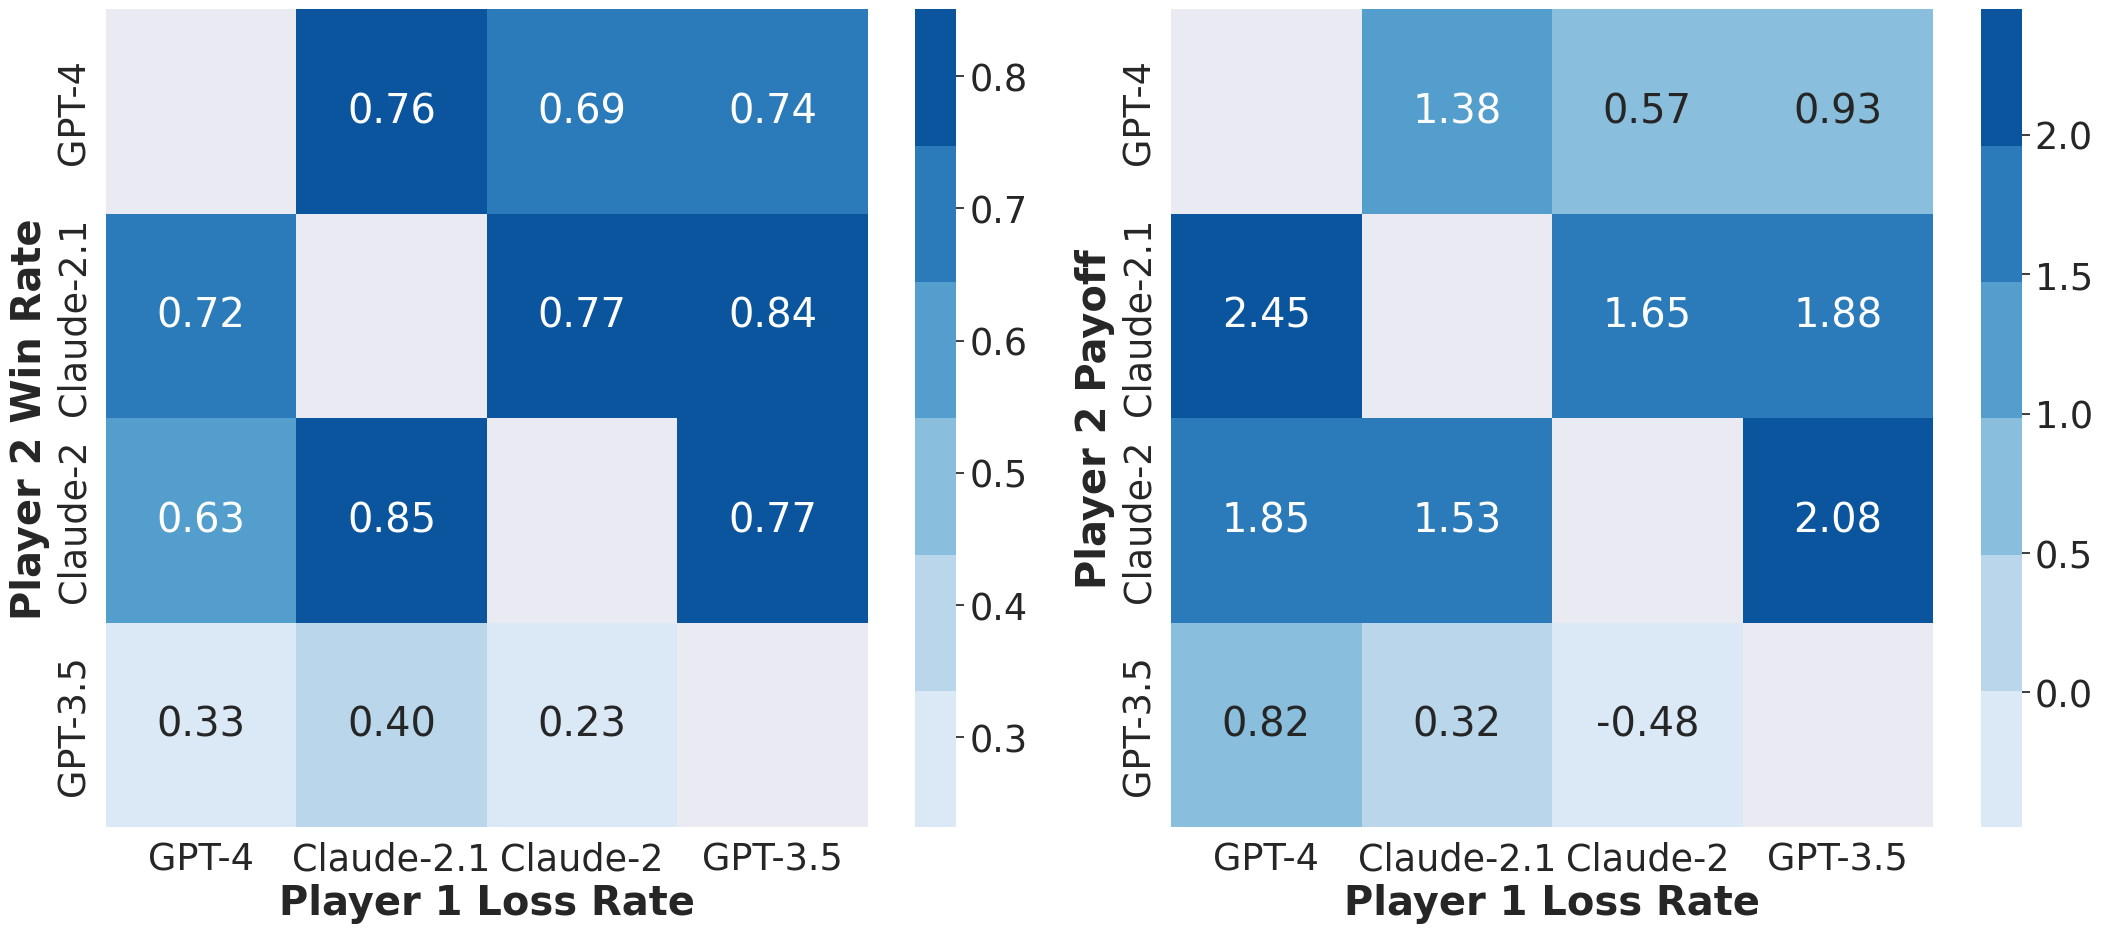

In [48]:
fig, axs = plt.subplots(figsize=(22,10), ncols=2)
fig.tight_layout()
aggregated = trading_aggregation(df.copy())


#######

# WinRate Plot

######
local_aggregate = aggregated.pivot(index="model_2", columns="model_1", values="win_2mean")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

# enlarging mask since we are adding the average
#mask = np.pad(mask, ((0,0),(0,1)), mode='constant', constant_values=False)
#local_aggregate["P2 Avg"] = local_aggregate.mean(axis=1)


first_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[0])
first_plot.set_ylabel('Player 2 Win Rate', fontdict=dict(weight='bold'))

first_plot.set_xlabel('Player 1 Loss Rate', fontdict=dict(weight='bold'))

#######

# Payoff Plot

######

local_aggregate = aggregated.pivot(index="model_2", columns="model_1", values="resource_delta_2mean")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

# enlarging mask since we are adding the sum

#mask = np.pad(mask, ((0,0),(0,1)), mode='constant', constant_values=False)
#local_aggregate["P2 Avg"] = local_aggregate.mean(axis=1)


second_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[1])
second_plot.set_ylabel('Player 2 Payoff', fontdict=dict(weight='bold'))
second_plot.set_xlabel('Player 1 Loss Rate', fontdict=dict(weight='bold'))

fig.tight_layout()

plt.savefig('figures/section_one_resource_exchange.pdf', bbox_inches='tight')
plt.show()

## Ultimatum

In [108]:
log_dir = "../experiments/section_one/.logs/ultimatum_multi_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

# we add 100 to restore the portion of money to P1
df["resource_delta_1"] = df["resource_delta_1"] + 100

# we set the delta of p1 to 0 of 100 ending games because it means they did not split the money
df.loc[df['resource_delta_1'] == 100, 'resource_delta_1'] = 0


# for some reasons this is not int, i have checked the data but does not seem corrupted?
# df[df["resource_delta_2"].apply(lambda x: isinstance(x, int))] returns all elements
df["resource_delta_1"] = df["resource_delta_1"].astype(int)


THERE ARE 720 log files
720 Loaded Successfully


In [50]:
def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()
    

    
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean']).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, df_copy.columns.values))
    return df_copy


ag = from_pandas_to_aggregation(df.copy())



In [113]:
smaller_df

,game_name,model_1,model_2,outcome_1,outcome_2,resource_delta_1,resource_delta_2,social_1,social_2,vals1,vals2
0,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 50,Dollars: 50,50,50,,,None,None
1,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 80,Dollars: 20,80,20,,,None,None
2,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 45,Dollars: 55,45,55,,,None,None
3,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 50,Dollars: 50,50,50,,,None,None
4,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 50,Dollars: 50,50,50,,,None,None
5,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 60,Dollars: 40,60,40,,,None,None
6,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 60,Dollars: 40,60,40,,,None,None
7,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 50,Dollars: 50,50,50,,,None,None
8,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 50,Dollars: 50,50,50,,,None,None
9,MultiTurnUltimatumGame,GPT-4,GPT-3.5,Dollars: 80,Dollars: 20,80,20,,,None,None


(59.6, 49.666666666666664)

### Win Rate

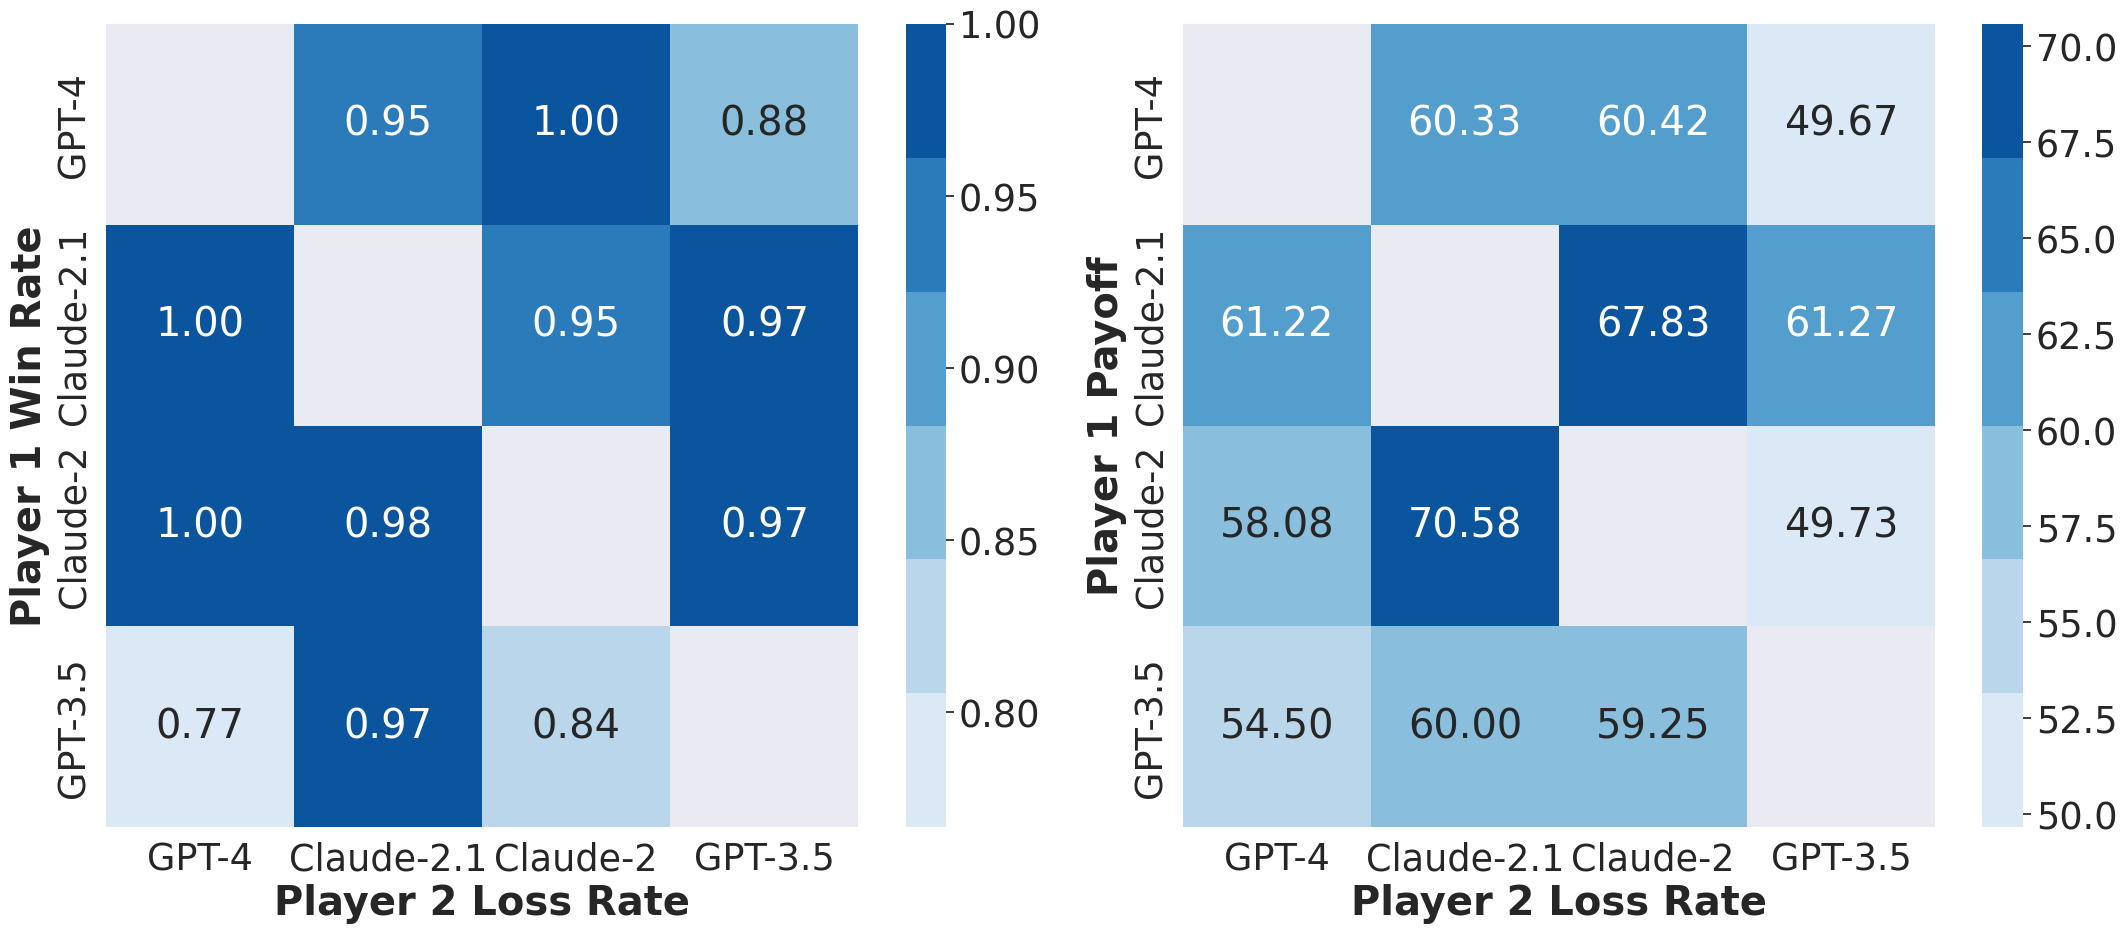

In [51]:
fig, axs = plt.subplots(figsize=(22,10), ncols=2)
fig.tight_layout()
aggregated = from_pandas_to_aggregation(df.copy())

# winrate plot
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="win_1mean")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

# enlarging mask since we are adding the sum
#mask = np.pad(mask, ((0,0),(0,1)), mode='constant', constant_values=False)
#local_aggregate["P1 Avg"] = local_aggregate.mean(axis=1)

first_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[0])
first_plot.set_ylabel('Player 1 Win Rate', fontdict=dict(weight='bold'))
first_plot.set_xlabel('Player 2 Loss Rate', fontdict=dict(weight='bold'))


# Payoff plot
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="resource_delta_1mean")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

# enlarging mask since we are adding the sum
#mask = np.pad(mask, ((0,0),(0,1)), mode='constant', constant_values=False)
#local_aggregate["P1 Avg"] = local_aggregate.mean(axis=1)

second_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[1])
#second_plot.set(ylabel=None)
#second_plot.set(xlabel="Payoff")
second_plot.set_ylabel('Player 1 Payoff', fontdict=dict(weight='bold'))
second_plot.set_xlabel('Player 2 Loss Rate', fontdict=dict(weight='bold'))

fig.tight_layout()
plt.savefig('figures/section_one_ultimatum.pdf', bbox_inches='tight')
plt.show()

# Seller and Buyer

In [133]:
log_dir = "../experiments/section_one/.logs/buysell_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
temp_df = compute_game_summary(game_states)


df = replace_names(temp_df.copy())

df["vals1"] = df["vals1"].apply(lambda x : x.valuation_dict["X"])
df["vals2"] = df["vals2"].apply(lambda x : x.valuation_dict["X"])

THERE ARE 914 log files
914 Loaded Successfully


### BuySell Payoffs

For each model, we want to extract the payoff against the other players

In [134]:
gb = df.groupby('vals1')    
seller_at_40, seller_at_60 = [gb.get_group(x).copy() for x in gb.groups]

In [135]:
assert seller_at_40.iloc[0]["vals1"] == 40
(seller_at_40["outcome_2"]==0).sum()

8

In [148]:
condition = (seller_at_40.model_1 == "GPT-3.5") & (seller_at_40.model_2 == "Claude-2.1")
smaller_df = seller_at_40[condition]


In [153]:
for a in (game_states[786].game_state[1:-1]):
    print(a["player_complete_answer"])
    print("-")

```xml
<proposal count> 0 </proposal count>
<my resources> X: 1 </my resources>
<my goals> Sell resources for 40 ZUP. It costed X: 40 ZUP to produce the resources </my goals>
<reason> I will start by proposing a trade to test the waters and see if there is interest in buying the object. </reason>
<player answer> PROPOSE </player answer>
<newly proposed trade> Player RED Gives X: 1 | Player BLUE Gives ZUP: 20 </newly proposed trade>
<message>Would you be interested in buying this object for 20 ZUP? </message>
```
-
 <proposal count>1</proposal count>
<my resources> ZUP: 100 </my resources> 
<my goals> Buy resources with <ZUP>. You are willing to pay at most X: 60 ZUP for the resources.</my goals>
<reason> The seller proposed 20 ZUP for the object, which is within my maximum willingness to pay of 60 ZUP. However, I think I can get it for less since my maximum is 60. I will counteroffer with a lower amount. </reason>
<player answer> PROPOSE </player answer>
<newly proposed trade> Player R

In [ ]:
condition_two = smaller_df["resource_delta_1"] != 0

smaller_df[condition_two]["resource_delta_1"].mean(), smaller_df["resource_delta_1"].mean()



#### Seller at 60

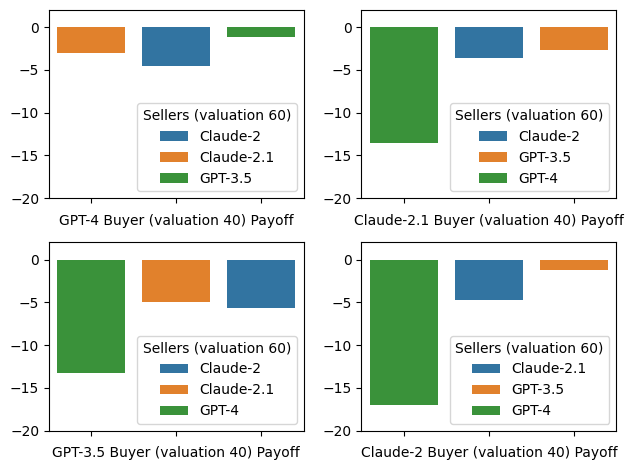

<Figure size 1000x2000 with 0 Axes>

In [9]:
fig, axs = plt.subplots(2,2)
plt.figure(figsize=(10,20))
fig.tight_layout()

for local_agent_plot, locs in zip(AGENTS_CLEAN_NAMES, [axs[0,0], axs[0,1], axs[1,1], axs[1,0]]):
    
    aggregated = seller_at_60.groupby(["model_1", "model_2"])[['outcome_1', 'outcome_2',
       'resource_delta_1', 'resource_delta_2']].mean().reset_index().copy()
    
    aggregated = aggregated[aggregated["model_2"].isin([local_agent_plot])]

    # names to plot things
    local_copy_of_agents = AGENTS_CLEAN_NAMES[:]
    local_copy_of_agents.remove(local_agent_plot)
    
    figu = sns.barplot(aggregated, x="model_1", y="outcome_2", order=local_copy_of_agents,
                       hue="model_1", dodge=False, ax=locs)
    
    figu.legend(title=f'Sellers (valuation 60)', loc='lower right')
    
    figu.set(ylabel=None)
    figu.set_ylim(-20, 2)
    figu.set(xlabel=f"{local_agent_plot} Buyer (valuation 40) Payoff")
    figu.set_xticklabels(labels=[])

fig.get_figure().savefig('figures/section_one_seller_at_60.pdf', bbox_inches='tight')
plt.show()

#### Seller at 40

In [16]:
import warnings

# SEM bars gives errors
warnings.filterwarnings('ignore')


In [17]:
import matplotlib.patches as mpatches

sns.set_context("poster")
sns.set_palette("colorblind")


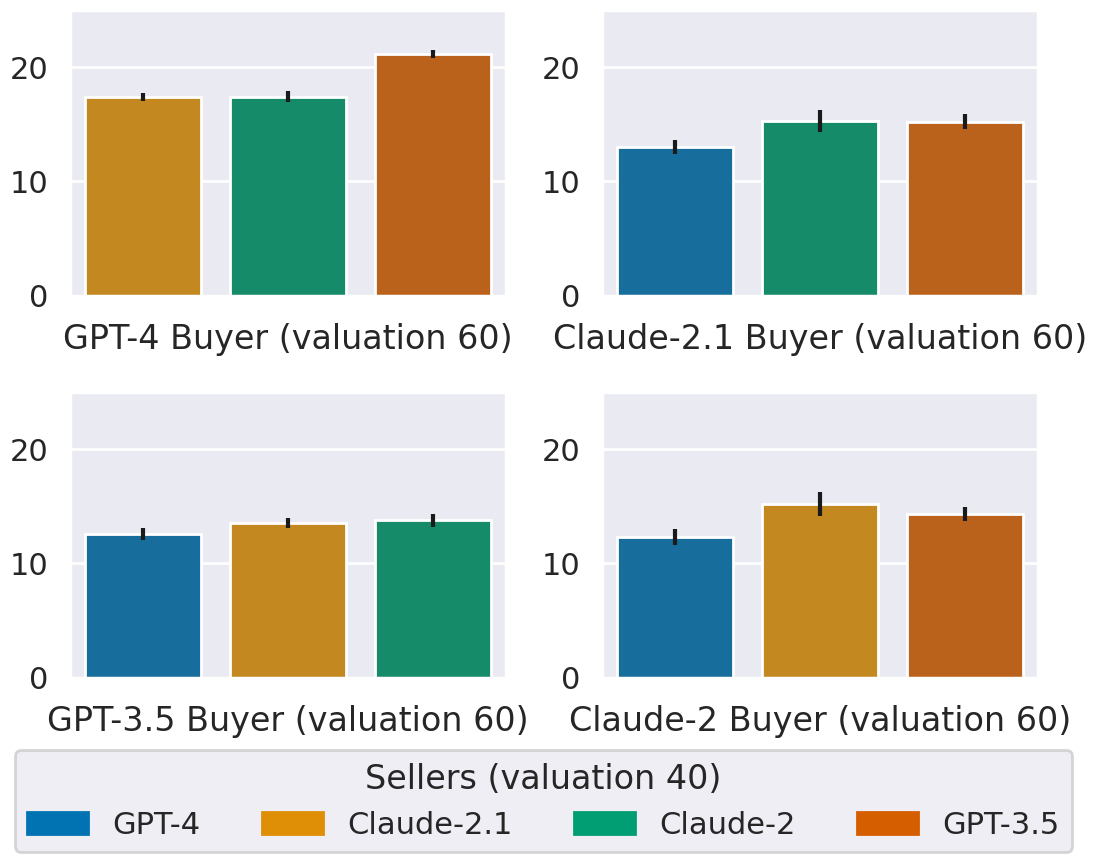

In [18]:
fig, axs = plt.subplots(2,2, figsize=(11,8))
fig.tight_layout()

unique = ['GPT-4', 'Claude-2.1', 'Claude-2', 'GPT-3.5']

palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

for local_agent_plot, locs in zip(AGENTS_CLEAN_NAMES, [axs[0,0], axs[0,1], axs[1,1], axs[1,0]]):
    
    aggregated = seller_at_40.groupby(["model_1", "model_2"])[['outcome_1', 'outcome_2',
           'resource_delta_1', 'resource_delta_2']].agg(['mean', "sem"]).reset_index().copy()
    aggregated.columns = list(map(''.join, aggregated.columns.values))

    aggregated = aggregated[aggregated["model_2"].isin([local_agent_plot])]

    # names to plot things
    local_copy_of_agents = AGENTS_CLEAN_NAMES[:]
    local_copy_of_agents.remove(local_agent_plot)
    
    figu = sns.barplot(aggregated, x="model_1", y="outcome_2mean", order=local_copy_of_agents,
                       hue="model_1", dodge=False, ax=locs, palette=palette,  yerr=aggregated["outcome_2sem"])
    figu.legend_.remove()
    #figu.legend(title=f'Sellers (valuation 40)', loc='upper right')
    
    figu.set(ylabel=None)
    figu.set_ylim(0, 25)
    figu.set(xlabel=f"{local_agent_plot} Buyer (valuation 60)")
    figu.set_xticklabels(labels=[])

#handles, labels = axs[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
custom_lines = [
    mpatches.RegularPolygon((0, 0), 5, radius=0.1, color=p) for p in list(palette.values())]
      
from matplotlib.lines import Line2D
fig.tight_layout()


axs[1,1].legend(custom_lines, palette.keys(), ncol=4, loc='upper center', bbox_to_anchor=(-0.135, -0.20), title=f'Sellers (valuation 40)')



fig.get_figure().savefig('figures/section_one_seller_at_40.pdf', bbox_inches='tight')
plt.show()